Task 2: Develop a “Tell-the-time” network



In [ ]:
pip install pydot graphviz


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D, BatchNormalization, Input, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow import optimizers
from keras.utils.vis_utils import plot_model


# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR'] if 'COLAB_TPU_ADDR' in os.environ else None

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER)  # TPU detection
    print('Running on TPU: ', tpu.master())
except ValueError:
    raise SystemError('TPU device not found')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU:  grpc://10.101.90.162:8470


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

labels = np.load('/content/drive/MyDrive/DL A1-T2/a2_data/labels.npy')

print(f"Labels shape: {labels.shape}")

images = np.load('/content/drive/MyDrive/DL A1-T2/data/images.npy')

print(f"Images shape: {images.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Labels shape: (18000, 2)
Images shape: (18000, 75, 75)


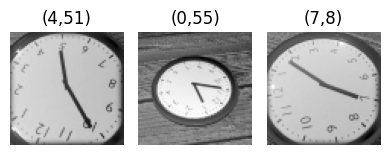

Image Properties:
- Shape: (18000, 75, 75)
- Data Type: uint8
- Pixel Value Range: 16 to 255


In [ ]:
# Data Exploration: Images

def plot_random_sample_images(images, labels, num_images=3):
    # Randomly select image indices
    random_indices = np.random.choice(len(images), num_images, replace=False)

    # Plot a 3x3 grid of images
    plt.figure(figsize=(4, 4))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[idx], cmap='gray')
        hour, minute = labels[idx]
        plt.title(f"({hour},{minute})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_random_sample_images(images, labels)

print("Image Properties:")
print(f"- Shape: {images.shape}")
print(f"- Data Type: {images.dtype}")
print(f"- Pixel Value Range: {images.min()} to {images.max()}")

In [ ]:
from collections import Counter

# Print some labels
print(labels[100:110])

# Convert each numpy array to a tuple
tuple_labels = [tuple(label) for label in labels]

# Count occurrences of each (hour, minute) label
label_counter = Counter(tuple_labels)

# Calculate the distribution
distribution = {label: count for label, count in label_counter.items()}

# Print the distribution
for label, count in distribution.items():
    print(f"Time {label[0]}:{label[1]} - Count: {count}")

[[0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]]
Time 0:0 - Count: 25
Time 0:1 - Count: 25
Time 0:2 - Count: 25
Time 0:3 - Count: 25
Time 0:4 - Count: 25
Time 0:5 - Count: 25
Time 0:6 - Count: 25
Time 0:7 - Count: 25
Time 0:8 - Count: 25
Time 0:9 - Count: 25
Time 0:10 - Count: 25
Time 0:11 - Count: 25
Time 0:12 - Count: 25
Time 0:13 - Count: 25
Time 0:14 - Count: 25
Time 0:15 - Count: 25
Time 0:16 - Count: 25
Time 0:17 - Count: 25
Time 0:18 - Count: 25
Time 0:19 - Count: 25
Time 0:20 - Count: 25
Time 0:21 - Count: 25
Time 0:22 - Count: 25
Time 0:23 - Count: 25
Time 0:24 - Count: 25
Time 0:25 - Count: 25
Time 0:26 - Count: 25
Time 0:27 - Count: 25
Time 0:28 - Count: 25
Time 0:29 - Count: 25
Time 0:30 - Count: 25
Time 0:31 - Count: 25
Time 0:32 - Count: 25
Time 0:33 - Count: 25
Time 0:34 - Count: 25
Time 0:35 - Count: 25
Time 0:36 - Count: 25
Time 0:37 - Count: 25
Time 0:38 - Count: 25
Time 0:39 - Count: 25
Time 0:40 - Count: 25
Time 0:41 - Count: 25
Time 0:42 - Cou

Classification 24 classes

In [ ]:
# Normalize pixel values
images_normalized = (images - 16) / (255 - 16)  # Normalize between 0 and 1 based on your dataset's pixel range

# Reshape images to have a single channel
images_reshaped = images_normalized.reshape((-1, 75, 75, 1))

# Convert hour and minute into a single label
# For each hour, there are two classes: one for the first half and one for the second half
classes_per_hour = 2
labels_class = (labels[:, 0] * classes_per_hour) + (labels[:, 1] // 30)

# One-hot encode the labels
labels_one_hot = to_categorical(labels_class, num_classes=24)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images_reshaped, labels_one_hot, test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential([
    Conv2D(32, (5, 5), input_shape=X_train.shape[1:], kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(),
    Dropout(0.25),

    Conv2D(64, (5, 5), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(),
    Dropout(0.25),

    Flatten(),
    Dropout(0.4),
    Dense(256, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),

    Dense(24, activation='softmax')
])

# Compile the model
model.compile(optimizer=optimizers.Nadam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model on the training data and validate on the validation set
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

# Get the final accuracy from the history object
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final training accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final validation accuracy: {final_val_accuracy * 100:.2f}%")


Epoch 1/20
450/450 [==============================] - 34s 66ms/step - loss: 3.9058 - accuracy: 0.0483 - val_loss: 3.7641 - val_accuracy: 0.0458
Epoch 2/20
450/450 [==============================] - 28s 63ms/step - loss: 3.6739 - accuracy: 0.0718 - val_loss: 3.5576 - val_accuracy: 0.0892
Epoch 3/20
450/450 [==============================] - 28s 63ms/step - loss: 3.4836 - accuracy: 0.1103 - val_loss: 3.4482 - val_accuracy: 0.1142
Epoch 4/20
450/450 [==============================] - 28s 63ms/step - loss: 3.2642 - accuracy: 0.1586 - val_loss: 3.2323 - val_accuracy: 0.1433
Epoch 5/20
450/450 [==============================] - 28s 63ms/step - loss: 3.0635 - accuracy: 0.2018 - val_loss: 3.5538 - val_accuracy: 0.0914
Epoch 6/20
450/450 [==============================] - 28s 63ms/step - loss: 2.8869 - accuracy: 0.2515 - val_loss: 3.4426 - val_accuracy: 0.1053
Epoch 7/20
450/450 [==============================] - 29s 63ms/step - loss: 2.7377 - accuracy: 0.2788 - val_loss: 3.1153 - val_accuracy:

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
def calculate_common_sense_error(y_true, y_pred):
    total_error = 0
    for true, pred in zip(y_true, y_pred):
        true_time_in_minutes = true[0] * 60 + true[1]
        pred_time_in_minutes = pred[0] * 60 + pred[1]

        diff = abs(true_time_in_minutes - pred_time_in_minutes)

        # Adjust the difference for the cyclical nature of a 12-hour clock
        if diff > 360:  # More than half of a 12-hour cycle
            diff = 720 - diff  # Subtract from total minutes in a 12-hour cycle

        total_error += diff

    common_sense_error = total_error / len(y_true)
    return common_sense_error

In [ ]:
# Predict on the validation set
y_pred_one_hot = model.predict(X_val)

# Convert the one-hot encoded predictions back to hour and minute format
y_pred_class = np.argmax(y_pred_one_hot, axis=1)
y_pred_hours = y_pred_class // classes_per_hour
y_pred_minutes = (y_pred_class % classes_per_hour) * 30

# Stack hours and minutes to create a 2D array for y_pred
y_pred = np.vstack((y_pred_hours, y_pred_minutes)).T

# Convert the one-hot encoded true labels back to hour and minute format for validation set
y_true_class = np.argmax(y_val, axis=1)
y_true_hours = y_true_class // classes_per_hour
y_true_minutes = (y_true_class % classes_per_hour) * 30

# Stack hours and minutes to create a 2D array for y_true
y_true = np.vstack((y_true_hours, y_true_minutes)).T

# Calculate the common sense error
error = calculate_common_sense_error(y_true, y_pred)
print(f"Common sense error on validation set: {error} minutes")

113/113 [==============================] - 1s 11ms/step
Common sense error on validation set: 47.266666666666666 minutes


Classification + Label Transformation


In [ ]:
# Assuming 'images' and 'labels' are already loaded with proper values
# Normalize pixel values
images_normalized = (images - 16) / (239)  # Normalize between 0 and 1 based on your dataset's pixel range

# Reshape images to have a single channel
images_reshaped = images_normalized.reshape((-1, 75, 75, 1))
import numpy as np

# Assuming 'labels' is a NumPy array with shape (n_samples, 2),
# where the first column contains the hours, and the second column contains the minutes.

# Convert the hours and minutes into their respective angles in radians
hours_in_radians = (labels[:, 0] + (labels[:, 1] / 60.0)) * 2 * np.pi / 12
minutes_in_radians = labels[:, 1] * 2 * np.pi / 60

# Calculate the sine and cosine for the angles
labels_hours_sin = np.sin(hours_in_radians)
labels_hours_cos = np.cos(hours_in_radians)
labels_minutes_sin = np.sin(minutes_in_radians)
labels_minutes_cos = np.cos(minutes_in_radians)

# Stack the sine and cosine values horizontally
labels_sin_cos = np.stack((labels_hours_sin, labels_hours_cos, labels_minutes_sin, labels_minutes_cos), axis=1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images_reshaped, labels_sin_cos, test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential([
    Conv2D(32, (5, 5), input_shape=X_train.shape[1:], kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(),
    Dropout(0.25),

    Conv2D(64, (5, 5), kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(),
    Dropout(0.25),

    Flatten(),
    Dropout(0.4),
    Dense(256, kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),

    Dense(4, activation='tanh')  # 4 output nodes for sin(hour), cos(hour), sin(minute), cos(minute)
])

# Compile the model with MeanSquaredError loss
model.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
              loss='mae',
              metrics=['accuracy'])

# Early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# Fit the model on the training data and validate on the validation set
history = model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping_callback])

# Predict on the validation set
y_pred_sin_cos = model.predict(X_val)

# Function to convert sin and cos back to time
def sin_cos_to_time(sin_val, cos_val, period):
    angle = np.arctan2(sin_val, cos_val)
    angle = np.mod(angle, 2 * np.pi)
    time = angle * (period / (2 * np.pi))
    return time

# Convert predictions back to hour and minute
y_pred_hours = sin_cos_to_time(y_pred_sin_cos[:, 0], y_pred_sin_cos[:, 1], 12).astype(int)
y_pred_minutes = sin_cos_to_time(y_pred_sin_cos[:, 2], y_pred_sin_cos[:, 3], 60).astype(int)

# Function to calculate common sense error
def calculate_common_sense_error(y_true, y_pred):
    total_error = 0
    for true, pred in zip(y_true, y_pred):
        true_time_in_minutes = true[0] * 60 + true[1]
        pred_time_in_minutes = pred[0] * 60 + pred[1]

        diff = abs(true_time_in_minutes - pred_time_in_minutes)

        # Adjust the difference for the cyclical nature of time
        if diff > 360:
            diff = 720 - diff

        total_error += diff

    common_sense_error = total_error / len(y_true)
    return common_sense_error

# Get the true times from the validation set (need to be in the same format as the predictions)
y_true_hours = sin_cos_to_time(y_val[:, 0], y_val[:, 1], 12).astype(int)
y_true_minutes = sin_cos_to_time(y_val[:, 2], y_val[:, 3], 60).astype(int)
y_true_combined = np.vstack((y_true_hours, y_true_minutes)).T

# Calculate the common sense error
error = calculate_common_sense_error(y_true_combined, np.vstack((y_pred_hours, y_pred_minutes)).T)
print(f"Common sense error on validation set: {error} minutes")


Epoch 1/20
113/113 [==============================] - 25s 190ms/step - loss: 0.7662 - accuracy: 0.2674 - val_loss: 0.7673 - val_accuracy: 0.2575
Epoch 2/20
113/113 [==============================] - 20s 174ms/step - loss: 0.6644 - accuracy: 0.3149 - val_loss: 0.9689 - val_accuracy: 0.2575
Epoch 3/20
113/113 [==============================] - 20s 173ms/step - loss: 0.5708 - accuracy: 0.3612 - val_loss: 1.0141 - val_accuracy: 0.2575
Epoch 4/20
113/113 [==============================] - 20s 177ms/step - loss: 0.5267 - accuracy: 0.3936 - val_loss: 0.9826 - val_accuracy: 0.2625
Epoch 5/20
113/113 [==============================] - 20s 176ms/step - loss: 0.5073 - accuracy: 0.4153 - val_loss: 0.8783 - val_accuracy: 0.2789
Epoch 6/20
113/113 [==============================] - 20s 176ms/step - loss: 0.4930 - accuracy: 0.4285 - val_loss: 0.6400 - val_accuracy: 0.3633
Epoch 7/20
113/113 [==============================] - 19s 172ms/step - loss: 0.4799 - accuracy: 0.4414 - val_loss: 0.4951 - val_ac

Classification 720 classes

In [ ]:
# Normalize pixel values
images_normalized = (images - 16) / (255 - 16)  # Normalize between 0 and 1 based on your dataset's pixel range

# Reshape images to have a single channel
images_reshaped = images_normalized.reshape((-1, 75, 75, 1))

# Convert hour and minute into a single label
# For each minute, there is a unique class (720 classes in total)
labels_class = (labels[:, 0] * 60 + labels[:, 1])

# One-hot encode the labels
labels_one_hot = to_categorical(labels_class, num_classes=720)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images_reshaped, labels_one_hot, test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential([
    Conv2D(32, (5, 5), input_shape=X_train.shape[1:], kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(),
    Dropout(0.25),

    Conv2D(64, (5, 5), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(),
    Dropout(0.25),

    Flatten(),
    Dropout(0.4),
    Dense(256, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),

    Dense(720, activation='softmax')  # 720 output neurons for all possible classes
])

# Compile the model
model.compile(optimizer=optimizers.Nadam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model on the training data and validate on the validation set
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))


def calculate_common_sense_error(y_true, y_pred):
    total_error = 0
    for true, pred in zip(y_true, y_pred):
        true_time_in_minutes = true[0] * 60 + true[1]
        pred_time_in_minutes = pred[0] * 60 + pred[1]

        diff = abs(true_time_in_minutes - pred_time_in_minutes)

        # Adjust the difference for the cyclical nature of a 12-hour clock
        if diff > 360:  # More than half of a 12-hour cycle
            diff = 720 - diff  # Subtract from total minutes in a 12-hour cycle

        total_error += diff

    common_sense_error = total_error / len(y_true)
    return common_sense_error


# Predict on the validation set
y_pred_one_hot = model.predict(X_val)

# Convert the one-hot encoded predictions back to hour and minute format
y_pred_minutes = y_pred_class % 60
y_pred_hours = y_pred_class // 60

# Stack hours and minutes to create a 2D array for y_pred
y_pred = np.vstack((y_pred_hours, y_pred_minutes)).T

# Convert the one-hot encoded true labels back to hour and minute format for validation set
y_true_minutes = y_true_class % 60
y_true_hours = y_true_class // 60

# Stack hours and minutes to create a 2D array for y_true
y_true = np.vstack((y_true_hours, y_true_minutes)).T

# Calculate Common Sense Error on the validation set
error = calculate_common_sense_error(y_true, y_pred)
print(f"Common Sense Error on validation set: {common_sense_error:.2f} minutes")


Epoch 1/20
450/450 [==============================] - 43s 69ms/step - loss: 7.2671 - accuracy: 0.0012 - val_loss: 7.1426 - val_accuracy: 0.0019
Epoch 2/20
450/450 [==============================] - 30s 66ms/step - loss: 7.1168 - accuracy: 0.0026 - val_loss: 7.1634 - val_accuracy: 0.0028
Epoch 3/20
450/450 [==============================] - 29s 65ms/step - loss: 7.0224 - accuracy: 0.0040 - val_loss: 7.1363 - val_accuracy: 0.0017
Epoch 4/20
450/450 [==============================] - 29s 65ms/step - loss: 6.9329 - accuracy: 0.0069 - val_loss: 7.1093 - val_accuracy: 0.0050
Epoch 5/20
450/450 [==============================] - 29s 64ms/step - loss: 6.8374 - accuracy: 0.0114 - val_loss: 7.0919 - val_accuracy: 0.0042
Epoch 6/20
450/450 [==============================] - 29s 65ms/step - loss: 6.7418 - accuracy: 0.0159 - val_loss: 7.0533 - val_accuracy: 0.0056
Epoch 7/20
450/450 [==============================] - 29s 65ms/step - loss: 6.6425 - accuracy: 0.0252 - val_loss: 7.0155 - val_accuracy:

Regression

In [ ]:
# Preprocess labels to have a continuous value
# Convert hour labels to float and normalize minutes to fraction of an hour
labels_continuous = labels[:, 0] + (labels[:, 1] / 60.0)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_continuous, test_size=0.2, random_state=42)

# Normalize the image data
X_train = (X_train - 16) / (255 - 16)
X_test = (X_test - 16) / (255 - 16)

# Reshape the input data to add the channel dimension (1 for grayscale)
X_train = X_train.reshape((*X_train.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))


# Define the CNN model architecture
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

# Compile the model with an optimizer and loss function suitable for regression
model.compile(optimizer=Nadam(), loss='mean_squared_error')

history = model.fit(
    X_train, y_train, epochs=20, batch_size=32,
    validation_split=0.1)

# Predict on the test set
predictions = model.predict(X_test).flatten()

def common_sense_error(preds, trues):
    # Ensure predictions and true values are within the 0-12 range
    preds = np.where(preds > 12, preds % 12, preds)
    trues = np.where(trues > 12, trues % 12, trues)

    # Calculate the shortest distance in the cycle, considering the cyclical nature of a clock
    error = np.minimum(np.abs(preds - trues), 12 - np.abs(preds - trues))

    # Convert hours to minutes and add the minute fraction
    error_hours = np.floor(error)
    error_minutes = (error - error_hours) * 60

    return np.mean(error_hours * 60 + error_minutes)

# Example usage with predictions and true labels
cs_error = common_sense_error(predictions, y_test)
print(f'Common sense error (in minutes): {cs_error}')


Epoch 1/20
270/270 [==============================] - 23s 74ms/step - loss: 28.5490 - val_loss: 36.3519
Epoch 2/20
270/270 [==============================] - 19s 69ms/step - loss: 15.1067 - val_loss: 25.0237
Epoch 3/20
270/270 [==============================] - 18s 68ms/step - loss: 13.6676 - val_loss: 12.7541
Epoch 4/20
270/270 [==============================] - 19s 69ms/step - loss: 13.2259 - val_loss: 19.0991
Epoch 5/20
270/270 [==============================] - 18s 68ms/step - loss: 12.5080 - val_loss: 15.1543
Epoch 6/20
270/270 [==============================] - 18s 68ms/step - loss: 11.7187 - val_loss: 12.5767
Epoch 7/20
270/270 [==============================] - 18s 68ms/step - loss: 11.2132 - val_loss: 14.3708
Epoch 8/20
270/270 [==============================] - 19s 69ms/step - loss: 10.3878 - val_loss: 12.3151
Epoch 9/20
270/270 [==============================] - 18s 68ms/step - loss: 10.0569 - val_loss: 12.4016
Epoch 10/20
270/270 [==============================] - 18s 68ms/

Multi-head models

Classification, Regression

In [ ]:
# Standardize images
standardized_imgs = (images - 16) / (239.0)

# Reformatting the images for the model
reformatted_imgs = standardized_imgs.reshape(-1, standardized_imgs.shape[1], standardized_imgs.shape[2], 1)

# Isolating hours and minutes from labels
hrs = labels[:, 0]
mins = labels[:, 1]

# One-hot encoding for hours
encoded_hrs = to_categorical(hrs, 12)

# Data partitioning
train_imgs, test_imgs, train_hrs, test_hrs, train_mins, test_mins = train_test_split(
    reformatted_imgs, encoded_hrs, mins, test_size=0.2, stratify=hrs, random_state=42
)

# Parameters configuration
parameters = {
    "activ_fn": "relu",
    "hr_loss": "categorical_crossentropy",
    "min_loss": "mean_squared_error",
    "filters": [32, 64],
    "kernel": (5, 5)
}

# Neural network structure
input_tensor = Input(shape=train_imgs.shape[1:])

first_conv = Conv2D(filters=parameters["filters"][0], kernel_size=parameters["kernel"], activation=parameters["activ_fn"])(input_tensor)
first_pool = AveragePooling2D()(first_conv)

# Branch for hours
second_conv_hr = Conv2D(filters=parameters["filters"][1], kernel_size=parameters["kernel"], activation=parameters["activ_fn"])(first_pool)
second_pool_hr = AveragePooling2D()(second_conv_hr)
dropout_hr = Dropout(0.5)(second_pool_hr)
flatten_hr = Flatten()(dropout_hr)
dense_hr = Dense(1024, activation=parameters["activ_fn"])(flatten_hr)
final_dropout_hr = Dropout(0.5)(dense_hr)
hrs_output = Dense(12, activation="softmax", name="output_hr")(final_dropout_hr)

# Branch for minutes
second_conv_min = Conv2D(filters=parameters["filters"][1], kernel_size=parameters["kernel"], activation=parameters["activ_fn"])(first_pool)
second_pool_min = AveragePooling2D()(second_conv_min)
flatten_min = Flatten()(second_pool_min)
dense_min = Dense(1024, activation=parameters["activ_fn"])(flatten_min)
mins_output = Dense(1, name="output_min")(dense_min)

# Model assembly
clock_model = Model(inputs=input_tensor, outputs=[hrs_output, mins_output])

# Model compilation
clock_model.compile(optimizer=Nadam(),
                    loss={'output_hr': parameters["hr_loss"], 'output_min': parameters["min_loss"]},
                    metrics={'output_hr': 'accuracy', 'output_min': 'mean_absolute_error'})

# Model training
training_process = clock_model.fit(train_imgs, {'output_hr': train_hrs, 'output_min': train_mins},
                                   validation_data=(test_imgs, {'output_hr': test_hrs, 'output_min': test_mins}),
                                   epochs=20, batch_size=32)

# Performance evaluation
evaluation_metrics = clock_model.evaluate(test_imgs, {'output_hr': test_hrs, 'output_min': test_mins})

# Displaying the outcomes
print(f'Accuracy for Hour Prediction: {evaluation_metrics[3]}')
print(f'Mean Absolute Error for Minute Prediction: {evaluation_metrics[4]}')

# Test set predictions
hour_minute_predictions = clock_model.predict(test_imgs)
predicted_hrs = np.argmax(hour_minute_predictions[0], axis=-1)
predicted_mins = hour_minute_predictions[1].squeeze()

# Error calculation considering the cyclical nature of time
def time_error(true_hrs, true_mins, est_hrs, est_mins):
    true_total_mins = np.add(np.multiply(true_hrs, 60), true_mins)
    est_total_mins = np.add(np.multiply(est_hrs, 60), est_mins)
    minute_differences = np.abs(true_total_mins - est_total_mins)
    minute_differences = np.minimum(minute_differences, 1440 - minute_differences)
    return np.mean(minute_differences)

# Conversion from one-hot to integers for hours
true_test_hrs = np.argmax(test_hrs, axis=1)

# Applying the error calculation
time_pred_error = time_error(true_test_hrs, test_mins, predicted_hrs, predicted_mins)
print(f'Common-sense Time Prediction Error: {time_pred_error} minutes')


Epoch 1/20
450/450 [==============================] - 60s 114ms/step - loss: 315.5829 - output_hr_loss: 2.4877 - output_min_loss: 313.0952 - output_hr_accuracy: 0.0816 - output_min_mean_absolute_error: 15.2220 - val_loss: 305.1676 - val_output_hr_loss: 2.4859 - val_output_min_loss: 302.6816 - val_output_hr_accuracy: 0.0833 - val_output_min_mean_absolute_error: 15.0197
Epoch 2/20
450/450 [==============================] - 50s 111ms/step - loss: 305.8351 - output_hr_loss: 2.4859 - output_min_loss: 303.3492 - output_hr_accuracy: 0.0833 - output_min_mean_absolute_error: 15.0299 - val_loss: 307.7761 - val_output_hr_loss: 2.4855 - val_output_min_loss: 305.2906 - val_output_hr_accuracy: 0.0833 - val_output_min_mean_absolute_error: 14.9827
Epoch 3/20
450/450 [==============================] - 50s 112ms/step - loss: 300.1659 - output_hr_loss: 2.4863 - output_min_loss: 297.6795 - output_hr_accuracy: 0.0817 - output_min_mean_absolute_error: 14.8075 - val_loss: 313.8312 - val_output_hr_loss: 2.520

Regression, Regression

In [ ]:
# Standardize images
standardized_imgs = (images - 16) / (239.0)

# Reformatting the images for the model
reformatted_imgs = standardized_imgs.reshape(-1, standardized_imgs.shape[1], standardized_imgs.shape[2], 1)

# Isolating hours and minutes from labels
hrs = labels[:, 0]
mins = labels[:, 1]

# Data partitioning
train_imgs, test_imgs, train_hrs, test_hrs, train_mins, test_mins = train_test_split(
    reformatted_imgs, hrs, mins, test_size=0.2, stratify=hrs, random_state=42
)

# Parameters configuration
parameters = {
    "activ_fn": "relu",
    "hr_loss": "mean_squared_error",  # Use MSE loss for regression
    "min_loss": "mean_squared_error",  # Use MSE loss for regression
    "filters": [32, 64],
    "kernel": (5, 5)
}

# Neural network structure
input_tensor = Input(shape=train_imgs.shape[1:])

first_conv = Conv2D(filters=parameters["filters"][0], kernel_size=parameters["kernel"], activation=parameters["activ_fn"])(input_tensor)
first_pool = AveragePooling2D()(first_conv)

# Branch for hours
second_conv_hr = Conv2D(filters=parameters["filters"][1], kernel_size=parameters["kernel"], activation=parameters["activ_fn"])(first_pool)
second_pool_hr = AveragePooling2D()(second_conv_hr)
dropout_hr = Dropout(0.5)(second_pool_hr)
flatten_hr = Flatten()(dropout_hr)
dense_hr = Dense(1024, activation=parameters["activ_fn"])(flatten_hr)
final_dropout_hr = Dropout(0.5)(dense_hr)
hrs_output = Dense(1, activation="linear", name="output_hr")(final_dropout_hr)  # Linear activation for regression

# Branch for minutes
second_conv_min = Conv2D(filters=parameters["filters"][1], kernel_size=parameters["kernel"], activation=parameters["activ_fn"])(first_pool)
second_pool_min = AveragePooling2D()(second_conv_min)
flatten_min = Flatten()(second_pool_min)
dense_min = Dense(1024, activation=parameters["activ_fn"])(flatten_min)
mins_output = Dense(1, activation="linear", name="output_min")(dense_min)  # Linear activation for regression

# Model assembly
clock_model = Model(inputs=input_tensor, outputs=[hrs_output, mins_output])

# Model compilation
clock_model.compile(optimizer=Nadam(),
                    loss={'output_hr': parameters["hr_loss"], 'output_min': parameters["min_loss"]},
                    metrics={'output_hr': 'mean_absolute_error', 'output_min': 'mean_absolute_error'})

# Model training
training_process = clock_model.fit(train_imgs, {'output_hr': train_hrs, 'output_min': train_mins},
                                   validation_data=(test_imgs, {'output_hr': test_hrs, 'output_min': test_mins}),
                                   epochs=20, batch_size=32)

# Performance evaluation
evaluation_metrics = clock_model.evaluate(test_imgs, {'output_hr': test_hrs, 'output_min': test_mins})

# Displaying the outcomes
print(f'Mean Absolute Error for Hour Prediction: {evaluation_metrics[3]}')
print(f'Mean Absolute Error for Minute Prediction: {evaluation_metrics[4]}')

# Test set predictions
hour_minute_predictions = clock_model.predict(test_imgs)
predicted_hrs = hour_minute_predictions[0].flatten()
predicted_mins = hour_minute_predictions[1].flatten()

# Calculate "common sense" error for time prediction
def time_error(true_hrs, true_mins, est_hrs, est_mins):
    true_total_mins = np.add(np.multiply(true_hrs, 60), true_mins)
    est_total_mins = np.add(np.multiply(est_hrs, 60), est_mins)
    minute_differences = np.abs(true_total_mins - est_total_mins)
    minute_differences = np.minimum(minute_differences, 1440 - minute_differences)
    return np.mean(minute_differences)

# Applying the error calculation
time_pred_error = time_error(test_hrs, test_mins, predicted_hrs, predicted_mins)
print(f'Common-sense Time Prediction Error: {time_pred_error} minutes')


Epoch 1/20
225/225 [==============================] - 32s 129ms/step - loss: 326.9113 - output_hr_loss: 13.9734 - output_min_loss: 312.9378 - output_hr_mean_absolute_error: 3.1513 - output_min_mean_absolute_error: 15.2078 - val_loss: 316.4877 - val_output_hr_loss: 11.9413 - val_output_min_loss: 304.5464 - val_output_hr_mean_absolute_error: 3.0004 - val_output_min_mean_absolute_error: 15.0653
Epoch 2/20
225/225 [==============================] - 28s 124ms/step - loss: 320.4484 - output_hr_loss: 12.3886 - output_min_loss: 308.0598 - output_hr_mean_absolute_error: 3.0333 - output_min_mean_absolute_error: 15.1439 - val_loss: 326.1622 - val_output_hr_loss: 11.8997 - val_output_min_loss: 314.2626 - val_output_hr_mean_absolute_error: 2.9964 - val_output_min_mean_absolute_error: 15.2048
Epoch 3/20
225/225 [==============================] - 28s 124ms/step - loss: 314.0605 - output_hr_loss: 12.3976 - output_min_loss: 301.6630 - output_hr_mean_absolute_error: 3.0345 - output_min_mean_absolute_err